## Downloading and extracting the Fashionpedia dataset

In [ ]:
# This creates a git filter that strips the notebook output when committing
!git config filter.strip-notebook-output.clean 'jupyter nbconvert --ClearOutputPreprocessor.enabled=True --to=notebook --stdin --stdout --log-level=ERROR'

# Download dataset (4 GB)
!mkdir fashionpedia
!mkdir fashionpedia/img

!curl https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip -o fashionpedia/train.zip
!unzip fashionpedia/train.zip -d fashionpedia/img
!rm fashionpedia/train.zip

!curl https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json -o fashionpedia/attributes.json

## Preprocess data

In [166]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import lib.fashionpedia_type as fpt
from tqdm.autonotebook import tqdm
from PIL import Image, ImageDraw, ImageOps

# Dataset sampling conditions
SUPERCATEGORY = 'upperbody'
DATASET_SIZE = 100
MIN_GARMENT_AREA = 1

In [81]:
with open('fashionpedia/attributes.json') as item:
    att: fpt.FashionPedia = json.load(item)

In [82]:
selected_cat = [cat for cat in att['categories'] if cat['supercategory'] == SUPERCATEGORY]
selected_cat_ids = [cat['id'] for cat in selected_cat]

print("Selected categories:", [cat['name'] for cat in selected_cat])

Selected categories: ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest']


In [83]:
def get_by_id(group, id):
    for item in att[group]:
        if item['id'] == id:
            return item

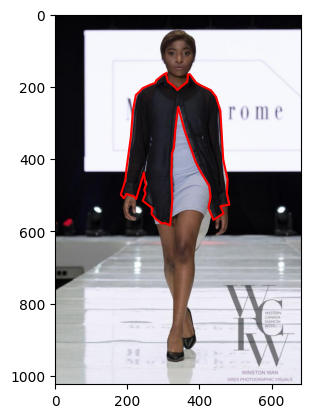

In [163]:
def show_segmentation(annotation: fpt.Annotation):
    file_name = get_by_id('images', annotation['image_id'])['file_name']
    img = mpimg.imread(f'fashionpedia/img/{file_name}')
    plt.imshow(img)

    seg = annotation['segmentation'][0]
    xs = seg[::2]
    ys = seg[1::2]
    plt.plot(xs, ys, c='red')

    plt.show()

test = get_by_id('annotations', 11)
print(test['area'])
show_segmentation(test)
        

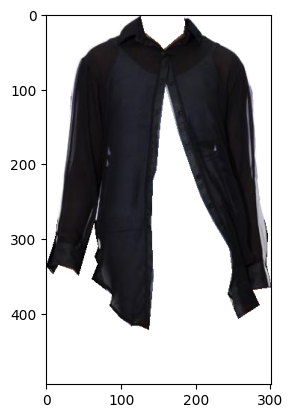

In [164]:
def crop_segmentation(annotation: fpt.Annotation):
    file_name = get_by_id('images', annotation['image_id'])['file_name']
    img = Image.open(f'fashionpedia/img/{file_name}')

    mask = Image.new('1', img.size, 0)

    # Mask
    seg = annotation['segmentation'][0]
    points = list(zip(*(iter(seg),) * 2))

    ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)

    # TODO: this makes all masked pixels transparent, but their color value is still the same, so the information is still there. We should make the masked pixels black or white first
    img.putalpha(mask)

    # crop to bounding box
    x, y, width, height = map(int, annotation['bbox'])
    cropped_image = img.crop((x, y, x + width, y + height))

    return cropped_image

test = get_by_id('annotations', 11)
plt.imshow(crop_segmentation(test))
plt.show()

In [168]:
dataset = []

for ann in att['annotations']:
    if not ann['category_id'] in selected_cat_ids:
        continue

    if ann['area'] < MIN_GARMENT_AREA:
        continue

    if type(ann['segmentation'][0]) != list:
        # skip images with RLE segmentation masks
        continue

    dataset.append({
            'fn': get_by_id('images', ann['image_id'])['file_name'],
            'img': crop_segmentation(ann),
            'cat': ann['category_id'],
            # TODO: currently there are 294 different attributes, we should probably pick a subset of attributes we want to focus on or combine attributes into classes.
            'att': ann['attribute_ids'],
        })
    
    if len(dataset) >= DATASET_SIZE:
        break

100

In [ ]:
# TODO: save preprocessed dataset

In [170]:
# Show all attributes
set(attrib['name'] for attrib in att['attributes'])

{'a-line',
 'above-the-hip (length)',
 'above-the-knee (length)',
 'abstract',
 'accordion (skirt)',
 'anorak',
 'applique(a)',
 'argyle',
 'asymmetric (collar)',
 'asymmetric (neckline)',
 'asymmetrical',
 'baggy',
 'ball gown (skirt)',
 'balloon',
 'banded (collar)',
 'basque (wasitline)',
 'bead(a)',
 'bell',
 'bell (sleeve)',
 'bell bottom',
 'below the knee (length)',
 'bermuda (shorts)',
 'biker (jacket)',
 'bishop (sleeve)',
 'blanket (coat)',
 'blazer',
 'bloomers',
 'blouson (dress)',
 'boardshorts',
 'boat (neck)',
 'bodycon (dress)',
 'bolero',
 'bomber (jacket)',
 'bone',
 'bootcut',
 'booty (shorts)',
 'bow (collar)',
 'buckled (opening)',
 'burnout',
 'camisole',
 'camo (pants)',
 'camouflage',
 'cap (sleeve)',
 'capri (pants)',
 'cargo (pants)',
 'cargo (pocket)',
 'cargo (shorts)',
 'cargo (skirt)',
 'cartoon',
 'chained (opening)',
 'chanel (jacket)',
 'check',
 'cheetah',
 'chelsea (collar)',
 'chemise (dress)',
 'cheongsams',
 'chevron',
 'choker (neck)',
 'circle',
